In [2]:
import rdkit
import pandas as pd
from rdkit import RDLogger
from rdkit import Chem
from rdkit.Chem import rdFingerprintGenerator
import time
import psutil
from rdkit.Chem import PandasTools
# Disables the C++ errors in RDKIT when forming mols
RDLogger.DisableLog('rdApp.*') 


In [3]:
RADIUS = 3
FPSIZE = 512
SAMPLE_SMILE = "c1cc(ccc1[C@H]([C@@H](CO)NC(=O)C(Cl)Cl)O)[N+](=O)[O-]"
RETURN_NUM_RESULTS = 200
SAMPLE_NAME = "result_files/CPU_fp_search_chembl_large_jupy"
CSV_REF_DB = "chembl_csv.csv"
CSV_REF_DB = "small_example.smi"

In [6]:
def prepare_smiles() -> list:
    # Takes a CSV and looks for a column named smiles
    start = time.time()
    db_smile_list = pd.read_csv(CSV_REF_DB, delimiter="\t", names=["smile"])
    #db_smile_list = pd.read_csv(CSV_REF_DB, names=["smile"])
    smile_list = []
    cleaned_mols = []
    for x in db_smile_list['smile']:
        mol = Chem.MolFromSmiles(x)
        if mol:
            cleaned_mols.append(mol)
            smile_list.append(x)
    # Getting % usage of virtual_memory ( 3rd field)
    print('RAM memory % used:', psutil.virtual_memory()[2])
    # Getting usage of virtual_memory in GB ( 4th field)
    print('RAM Used (GB):', psutil.virtual_memory()[3]/1000000000)
    del db_smile_list
    # cleaned_mols = [x for x in mols if x is not None]
    # smile_list = [Chem.MolToSmiles(x) for x in cleaned_mols]
    # smile_list_df = pd.DataFrame(smile_list)

    end = time.time()
    print(f"{end - start} seconds to read in {len(smile_list)} files")
    return cleaned_mols, smile_list

def generate_fps(cleaned_mols: list) -> list("ExplicitBitVect"):
    # Generate FP for db smiles
    mfpgen = rdFingerprintGenerator.GetMorganGenerator(radius=RADIUS,fpSize=FPSIZE)
    return [mfpgen.GetFingerprint(m) for m in cleaned_mols]

def gen_sample_fps(sample_smile: list) -> list("ExplicitBitVect"):
    # Generate FP for submitted/sample smile
    mol = Chem.MolFromSmiles(sample_smile)
    mfpgen_example = rdFingerprintGenerator.GetMorganGenerator(radius=RADIUS,fpSize=FPSIZE)
    return mfpgen_example.GetFingerprint(mol)

def gen_tanimoto(sample_fps, ref_fps) -> list("tanimoto_Results"):
    # perform tanimoto
    rdkit.DataStructs.cDataStructs.BulkTanimotoSimilarity(sample_fps, ref_fps)
    return rdkit.DataStructs.cDataStructs.BulkTanimotoSimilarity(sample_fps, ref_fps)

def results_to_df(tanimoto_results, smile_from_db) -> pd.DataFrame:
    # Convert results to numpy
    result_df = pd.DataFrame(tanimoto_results, columns=["similarity"])
    result_df["smiles"] = smile_from_db
    return result_df.sort_values(by="similarity", ascending=False).head(RETURN_NUM_RESULTS).round(2)

RAM memory % used: 29.6
RAM Used (GB): 10.170343424
0.3701140880584717 seconds to read in 2785 files


c:\Users\sulsb\OneDrive\Desktop\gpu\cuda\lib\site-packages\rdkit\Chem\Draw\IPythonConsole.py:261: UserWarning: Truncating the list of molecules to be displayed to 50. Change the maxMols value to display more.
  warnings.warn(


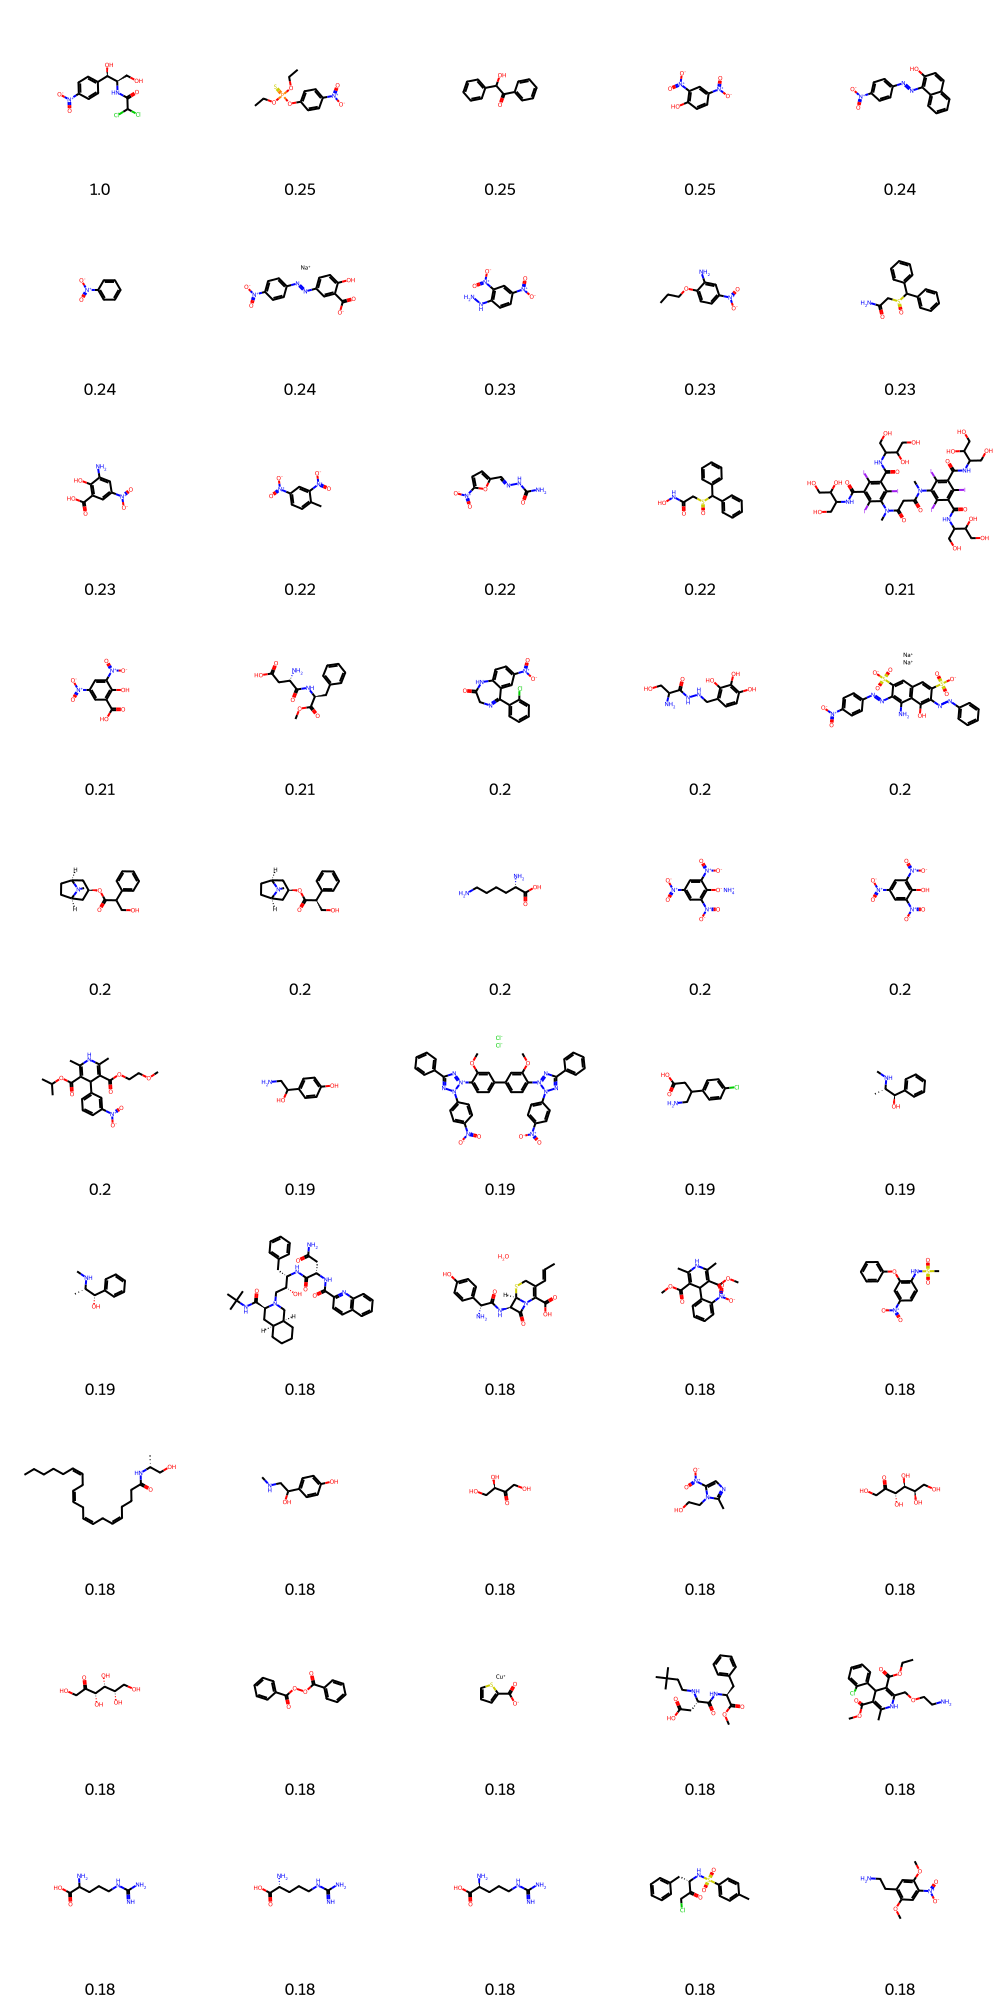

In [7]:

cleaned_mols, smile_from_db = prepare_smiles()
ref_fps = generate_fps(cleaned_mols)
sample_fps = gen_sample_fps(SAMPLE_SMILE)
tanimoto_results = gen_tanimoto(sample_fps, ref_fps)
results = results_to_df(tanimoto_results, smile_from_db)
results.to_csv(f"{SAMPLE_NAME}")
from rdkit.Chem import PandasTools
PandasTools.AddMoleculeColumnToFrame(results, smilesCol='smiles')
PandasTools.FrameToGridImage(results, legendsCol="similarity", molsPerRow=5)
